In [2]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos

<Figure size 432x288 with 0 Axes>

In this notebook, we compare the correlations between human similarity data with the cosine distance matrices of the full BERT embeddings and the subsets of the embeddings we found were useful in WSD.

## Data Prep

In [3]:
db = access_db()
results, corrs = get_results_users(db)

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


In [4]:
min_time = corrs.drop('userID', axis = 1).apply(np.mean)['timeTaken'] - corrs.drop('userID', axis = 1).apply(np.std)['timeTaken']
incl_users = corrs[(corrs['timeTaken'] > min_time) & ((corrs['Group Consistency'] > 0.4) | (corrs['Self Consistency'] > 0.2))]['userID']
incl_users = incl_users.tolist()

In [5]:
shared_words = ['foot_n', 'table_n', 'plane_n', 'degree_n', 'right_n', 'model_n']
lemma_counts = get_lemma_counts(results, incl_users, db)
test_repeat_words = lemma_counts[lemma_counts['num_trials'] > 10]['lemma'].tolist()
all_words = shared_words + test_repeat_words

In [47]:
def get_test_result_data(results, w, incl_users):
    test_means = mean_distance_mtx(results, w, 'test', incl_users, normalize = True)
    repeat_means = mean_distance_mtx(results, w, 'repeat', incl_users, normalize = True)
    expt_means = test_means
    if repeat_means.shape:
        expt_means = np.mean([test_means, repeat_means], axis = 0)
        expt_means /= np.max(expt_means)
    return expt_means

In [6]:
matrices = {}
for w in all_words:
    matrices[w] = {}
    word, pos = w.split('_')
    cs_mtx_full, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    use_masc = False, normalize = True)
    matrices[w]['bert_full'] = cs_mtx_full
    if w in test_repeat_words:
        expt_mtx = get_test_result_data(results, w, incl_users)
    else:
        expt_mtx = mean_distance_mtx(results, w, 'shared', incl_users, normalize = True)
    matrices[w]['expt'] = expt_mtx
    cs_mtx_sel, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    corpus = 'select_weights', use_masc = False, normalize = True)
    matrices[w]['bert_selected'] = cs_mtx_sel

In [7]:
all_human_avg = [matrices[w]['expt'] for w in all_words]
all_bert_full = [matrices[w]['bert_full'] for w in all_words]
all_bert_sel = [matrices[w]['bert_selected'] for w in all_words]

In [8]:
results['num_senses'] = results['lemma'].apply(get_num_senses, args = [db])
results['pos'] = results['lemma'].apply(get_pos, args = ['_'])
all_trials = results[results['lemma'].isin(all_words) & (results['userID'].isin(incl_users))]

## Global Correlations

In [10]:
pd.DataFrame(pd.Series({'Embeddings with Nonzero Weights': mtx_correlation(all_human_avg, all_bert_sel, method = 'pearson'),
'Full Embeddings': mtx_correlation(all_human_avg, all_bert_full, method = 'pearson')}),
             columns = ['Pearson Correlation with Average Reported Distance'])

,Pearson Correlation with Average Reported Distance
Embeddings with Nonzero Weights,0.514009
Full Embeddings,0.543036


## POS Correlations

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 720x576 with 0 Axes>

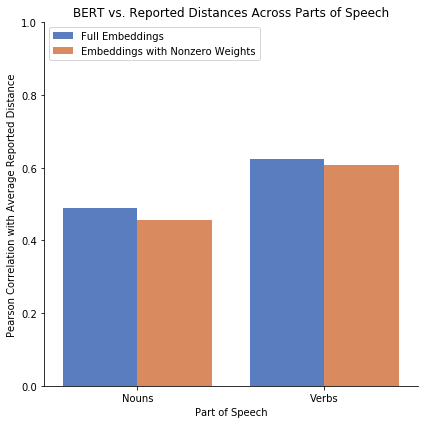

In [50]:
pos_results = []
for e in ['bert_full', 'bert_selected']:
    if e == 'bert_full':
        legend_val = "Full Embeddings"
    else:
        legend_val = "Embeddings with Nonzero Weights"
    for p in ['n', 'v']:
        if p == 'n':
            pos_label = 'Nouns'
        else:
            pos_label = 'Verbs'
        pos_results.append({"BERT Embedding Type": legend_val, "Part of Speech": pos_label, 
                            "Pearson Correlation with Average Reported Distance": containing_query(all_trials, 'pos', [p], matrices, bert_key = e)})
pos_results = pd.DataFrame(pos_results)
plt.figure(figsize = (10, 8))
sns.catplot(x="Part of Speech", y="Pearson Correlation with Average Reported Distance", hue="BERT Embedding Type",
            data=pos_results, legend = False,
                height=6, kind="bar", palette="muted")
plt.title("BERT vs. Reported Distances Across Parts of Speech")
plt.ylim(0, 1)

plt.tight_layout()
plt.legend(loc = 'upper left')
plt.savefig("../../results/figures/pos_cos_corr.png")

## Correlation with Number of Senses

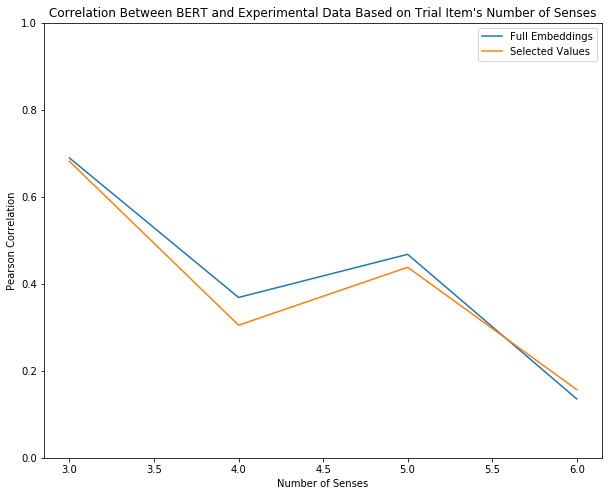

In [58]:
plt.figure(figsize = (10, 8))
plt.plot(range(3, 7),
         [containing_query(all_trials, 'num_senses', [i], matrices, bert_key = 'bert_full') for i in range(3, 7)], label = 'Full Embeddings')
plt.plot(range(3, 7),
         [containing_query(all_trials, 'num_senses', [i], matrices, bert_key = 'bert_selected') for i in range(3, 7)], label = 'Selected Values')
plt.xlabel("Number of Senses")
plt.ylabel("Pearson Correlation")
plt.title("Correlation Between BERT and Experimental Data Based on Trial Item's Number of Senses")
plt.legend()
plt.ylim(0, 1)
plt.savefig('../../results/figures/num_senses_corr.png')

In [14]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types.csv')
semcor_entropy.drop("Unnamed: 0", axis = 1, inplace = True)
semcor_entropy['lemma'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
semcor_entropy.drop('Lemma', axis = 1, inplace = True)
all_entropy = all_trials.merge(semcor_entropy, on = 'lemma')

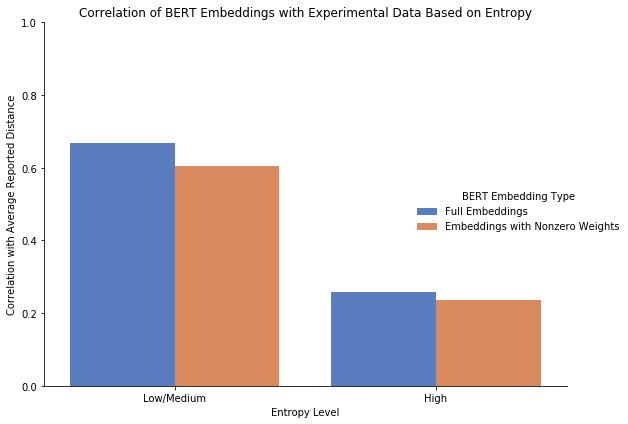

In [51]:
entropy_results = []
for e in ['bert_full', 'bert_selected']:
    if e == 'bert_full':
        legend_val = "Full Embeddings"
    else:
        legend_val = "Embeddings with Nonzero Weights"

    for b in [(0, 1.45), (1.45, 2.5)]:
        corr_for_ent = range_query(all_entropy, 'entropy', b[0], b[1], matrices, bert_key = e)
        if b[0] == 0:
            ent_level = 'Low/Medium'
        else:
            ent_level = 'High'
        entropy_results.append({"Entropy Level": ent_level, 'BERT Embedding Type': legend_val,
                                    "Correlation with Average Reported Distance": corr_for_ent})
entropy_results = pd.DataFrame(entropy_results)
sns.catplot(x="Entropy Level", y="Correlation with Average Reported Distance", hue="BERT Embedding Type", data=entropy_results,
                height=6, kind="bar", palette="muted")
plt.title("Correlation of BERT Embeddings with Experimental Data Based on Entropy")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('../../results/figures/entropy_corr.png')

## Comparing Experimental Data with Confusion Matrices

In [62]:
with open('../data/test_confusion_matrices.json', 'r') as f:
    confusion_mtx = json.load(f)

In [65]:
for w in matrices:
    if w in confusion_mtx:
        matrices[w]['confusion'] = confusion_mtx[w]

In [103]:
test_human_avg = [matrices[w]['expt'].flatten().tolist() for w in test_repeat_words]
conf = [matrices[w]['confusion'] for w in test_repeat_words]
flatten = lambda l: [item for sublist in l for item in sublist]
print("Spearman Correlation between Human Data and Confusion Matrices",
      mtx_correlation(flatten(test_human_avg), flatten(flatten(conf)), confusion = True))

Spearman Correlation between Human Data and Confusion Matrices -0.6313951674674304


In [121]:
def containing_query(df, value, selection_criteria, dist_mtx_dict, bert_key = 'bert'):
    words_with_crit = df[df[value].isin(selection_criteria)]['lemma'].unique()
    data_for_words = {w : dist_mtx_dict[w] for w in words_with_crit}
    if bert_key == 'confusion':
        expt_data = [matrices[w]['expt'].flatten().tolist() for w in data_for_words]
        conf_matrices = [data_for_words[w][bert_key] for w in data_for_words]
        return mtx_correlation(flatten(expt_data), flatten(flatten(conf_matrices)), confusion = True)
    return mtx_correlation([data_for_words[w]['expt'] for w in data_for_words],
                          [data_for_words[w][bert_key] for w in data_for_words], method = 'pearson')

def range_query(df, value, low, high, dist_mtx_dict, bert_key = 'bert'):
    #Inclusive of low and high
    words_with_crit = df[(df[value] >= low) & (df[value] <= high)]['lemma'].unique()
    data_for_words = {w : dist_mtx_dict[w] for w in words_with_crit}
    if bert_key == 'confusion':
        expt_data = [matrices[w]['expt'].flatten().tolist() for w in data_for_words]
        conf_matrices = [data_for_words[w][bert_key] for w in data_for_words]
        return mtx_correlation(flatten(expt_data), flatten(flatten(conf_matrices)), confusion = True)

    return mtx_correlation([data_for_words[w]['expt'] for w in data_for_words],
                          [data_for_words[w][bert_key] for w in data_for_words], method = 'pearson')


In [113]:
test_rep_matrices = {k:v for k,v in matrices.items() if k in test_repeat_words}
test_rep_trials = all_trials[all_trials['trialType'].isin(['test', 'repeat'])]
for p in ['n', 'v']:
    print(p, "Correlation with Average Reported Distance",
          containing_query(test_rep_trials, 'pos', [p], test_rep_matrices, bert_key = 'confusion'))


n Correlation with Average Reported Distance -0.6588724183545459
v Correlation with Average Reported Distance -0.581205431868766


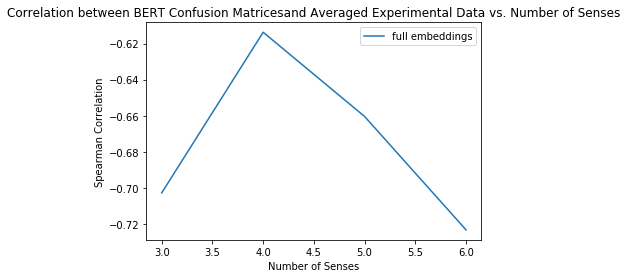

In [115]:
plt.plot(range(3, 7),
         [containing_query(test_rep_trials, 'num_senses', [i],
                           test_rep_matrices, bert_key = 'confusion') for i in range(3, 7)], label = 'full embeddings')
plt.xlabel("Number of Senses")
plt.ylabel("Spearman Correlation")
plt.title("Correlation between BERT Confusion Matricesand Averaged Experimental Data vs. Number of Senses")
plt.legend()

In [126]:
test_rep_entropy = all_entropy[all_entropy['trialType'].isin(['test', 'repeat'])]

print("Correlation for med/low entropy words", range_query(test_rep_entropy, 'entropy', 0, 1.45,
                                                       test_rep_matrices, bert_key = 'confusion'))

Correlation for med/low entropy words -0.778875441409051


In [128]:
print("Correlation for high entropy words", range_query(test_rep_entropy, 'entropy', 1.45, 2,
                                                       test_rep_matrices, bert_key = 'confusion'))

Correlation for high entropy words -0.5552614666622168
